In [187]:
## Cargamos paquetes
import os
import pandas as pd
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import rioxarray as rxr
import numpy as np
import fiona
import rasterio.mask


In [121]:
## Función que construye directorio de datos
def build_path(PATH):
    return os.path.abspath(os.path.join(*PATH))

## Ruta del notebook
FILE_PATH = os.getcwd()

## Ruta de los rasters
DATA_PATH = build_path(["..", "..", "data", "reto"])
RASTER_PATH = build_path([DATA_PATH, "rasters"])
BIOCLIM_PATH = build_path([RASTER_PATH, "WorldClim", "BioClim"])
CLIM_PATH = build_path([RASTER_PATH, "WorldClim", "Climate"])
SRAD_CLIM_PATH = build_path([CLIM_PATH, "srad"])
WIND_CLIM_PATH = build_path([CLIM_PATH, "wind"])

## Ruta de las power plants
POWER_PLANTS_PATH = build_path([DATA_PATH, "global_power_plants"])

## Ruta de los polígonos de paises
COUNTRIES_PATH = build_path([DATA_PATH, "countries"])

## Ruta de polígonos de los casos de estudio
CASOS_ESTUDIO_PATH = build_path([DATA_PATH, "casos_estudio"])
CHIAPAS_PATH = build_path([CASOS_ESTUDIO_PATH, "chiapas"])
SONORA_PATH = build_path([CASOS_ESTUDIO_PATH, "sonora"])
CHIHUAHUA_PATH = build_path([CASOS_ESTUDIO_PATH, "chihuahua"])

## Carguemos un archivo Raster para visualizarlo

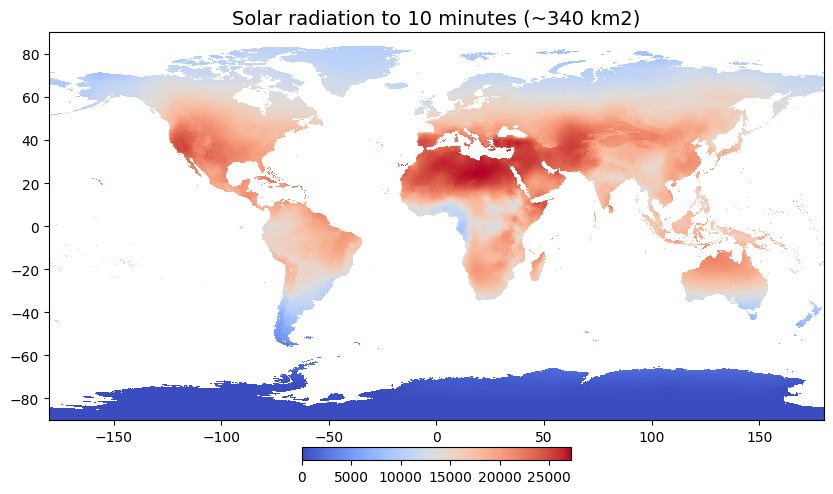

In [11]:
## Cargamos el raster de WorldClim de radiación solar

### Construye ruta
SRAD_FP = build_path([RASTER_PATH, "WorldClim", "Climate", "srad", "wc2.1_10m_srad_08.tif"])

### Carga raster
raster = rxr.open_rasterio(SRAD_FP, mask_and_scale=True)

### Selecciona datos en banda 1
raster =  raster.sel(band=1)

### Grafica el raster
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)

cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.025,
    'pad': 0.05,
    'extend':'neither'
}

raster.plot.imshow(
    ax=ax,  add_labels=False,
    cmap='coolwarm', cbar_kwargs=cbar_kwargs)

ax.set_title('Solar radiation to 10 minutes (~340 km2)', fontsize = 14)
ax.set_aspect('equal')
plt.show()

## Carguemos datos de Power Plants

In [23]:
## Construye ruta
PP_FP = build_path([POWER_PLANTS_PATH, "global_power_plant_database.csv"]) 

## Cargamos los datos con pandas
plantas = pd.read_csv(PP_FP)

## Extraemos la ubicación en longitud y latitud de las plantas para construir el geo Data Frame
geometry = gpd.points_from_xy(plantas.longitude, plantas.latitude)

gdf = gpd.GeoDataFrame(plantas, crs='EPSG:4326', geometry=geometry)
gdf


/tmp/ipykernel_1379223/3742212284.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  plantas = pd.read_csv(PP_FP)


,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017,geometry
0,AFG,Afghanistan,Kajaki Hydroelectric Power Plant Afghanistan,GEODB0040538,33.0,32.3220,65.1190,Hydro,NaN,NaN,...,162.90,97.39,137.76,119.50,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (65.119 32.322)
1,AFG,Afghanistan,Kandahar DOG,WKS0070144,10.0,31.6700,65.7950,Solar,NaN,NaN,...,17.48,18.25,17.70,18.29,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (65.795 31.67)
2,AFG,Afghanistan,Kandahar JOL,WKS0071196,10.0,31.6230,65.7920,Solar,NaN,NaN,...,17.58,19.10,17.62,18.72,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (65.792 31.623)
3,AFG,Afghanistan,Mahipar Hydroelectric Power Plant Afghanistan,GEODB0040541,66.0,34.5560,69.4787,Hydro,NaN,NaN,...,203.55,146.90,230.18,174.91,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (69.4787 34.556)
4,AFG,Afghanistan,Naghlu Dam Hydroelectric Power Plant Afghanistan,GEODB0040534,100.0,34.6410,69.7170,Hydro,NaN,NaN,...,357.22,270.99,395.38,350.80,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (69.717 34.641)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34931,ZMB,Zambia,Ndola,WRI1022386,50.0,-12.9667,28.6333,Oil,NaN,NaN,...,NaN,NaN,NaN,183.79,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1,POINT (28.6333 -12.9667)
34932,ZMB,Zambia,Nkana,WRI1022384,20.0,-12.8167,28.2000,Oil,NaN,NaN,...,NaN,NaN,NaN,73.51,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1,POINT (28.2 -12.8167)
34933,ZMB,Zambia,Victoria Falls,WRI1022380,108.0,-17.9167,25.8500,Hydro,NaN,NaN,...,575.78,548.94,579.90,578.32,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (25.85 -17.9167)
34934,ZWE,Zimbabwe,Hwange Coal Power Plant Zimbabwe,GEODB0040404,920.0,-18.3835,26.4700,Coal,NaN,NaN,...,NaN,NaN,NaN,2785.10,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1,POINT (26.47 -18.3835)


In [24]:
## Haremos un subset para quedarnos con los registros de plantas solares o eólicas
energia = "Solar" # "Wind" si queremos quedarnos con las plantas eólicas
gdf_energia = gdf.query(f"primary_fuel == '{energia}'")
gdf_energia


,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017,geometry
1,AFG,Afghanistan,Kandahar DOG,WKS0070144,10.0,31.670,65.795,Solar,NaN,NaN,...,17.48,18.25,17.70,18.29,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (65.795 31.67)
2,AFG,Afghanistan,Kandahar JOL,WKS0071196,10.0,31.623,65.792,Solar,NaN,NaN,...,17.58,19.10,17.62,18.72,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (65.792 31.623)
17,DZA,Algeria,Adrar,WKS0068905,20.0,27.908,-0.317,Solar,NaN,NaN,...,35.22,34.22,35.33,35.17,NO-ESTIMATION,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (-0.317 27.908)
18,DZA,Algeria,Ain Azel,WKS0065285,20.0,35.880,5.475,Solar,NaN,NaN,...,38.68,37.56,38.37,38.75,NO-ESTIMATION,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (5.475 35.88)
20,DZA,Algeria,Ain Sekhouna,WKS0068919,20.0,34.532,0.804,Solar,NaN,NaN,...,34.85,33.67,34.54,35.46,NO-ESTIMATION,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (0.804 34.532)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34833,VNM,Vietnam,Ninh Thuận CMX,WKS0067920,168.0,11.700,108.900,Solar,NaN,NaN,...,346.18,381.66,324.99,283.13,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (108.9 11.7)
34847,VNM,Vietnam,Phước Nam,WKS0071353,330.0,11.446,108.866,Solar,NaN,NaN,...,672.49,728.74,626.62,576.93,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (108.866 11.446)
34894,VNM,Vietnam,Thua Thien Hue TTC,WKS0073963,48.0,16.440,107.505,Solar,NaN,NaN,...,92.05,98.76,85.27,78.68,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (107.505 16.44)
34895,VNM,Vietnam,Thuan Bac,WKS0072323,204.0,11.700,109.030,Solar,NaN,NaN,...,419.98,463.11,394.00,340.91,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (109.03 11.7)


Text(0.5, 1.0, 'Distribución de Plantas de energía Solar')

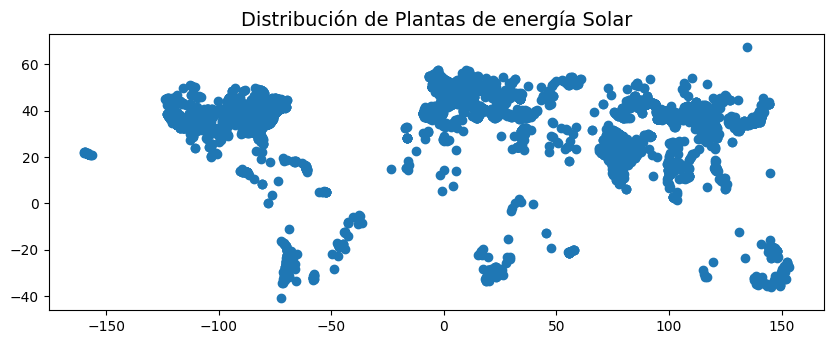

In [33]:
## Visualizamos la distribución de plantas en el mundo
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)

gdf_energia.plot( ax=ax)

ax.set_title(f'Distribución de Plantas de energía {energia}', fontsize = 14)


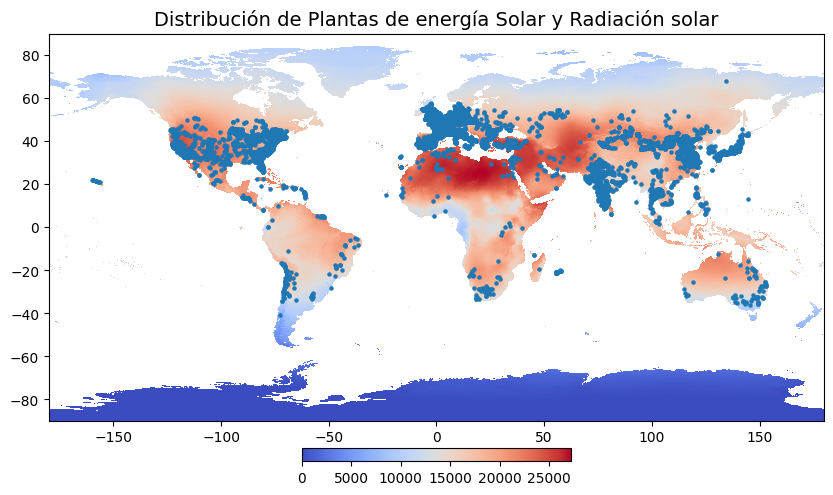

In [34]:
### Traslapemos los puntos de plantas de energía sobre el raster de radiación solar

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)

cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.025,
    'pad': 0.05,
    'extend':'neither'
}

raster.plot.imshow(
    ax=ax, add_labels=False,
    cmap='coolwarm', cbar_kwargs=cbar_kwargs)
gdf_energia.plot(ax=ax, markersize=5)
ax.set_xlim([raster.x.min(), raster.x.max()])
ax.set_ylim([raster.y.min(), raster.y.max()])
ax.set_title(f'Distribución de Plantas de energía {energia} y Radiación solar', fontsize = 14)
ax.set_aspect('equal')

plt.show()

## Sampling Raster Values

Vamos a extraer el valor de los pixeles del raster en cada punto geográfico de las plantas de poder. El método `sel()` de Xarray permite extraer el valor del pixel para un punto en específico.

In [37]:
## Convertimos las coordenadas a DataArray
x_coords = gdf.geometry.x.to_xarray()
y_coords = gdf.geometry.y.to_xarray()

## Obtenemos el valor del pixel para esas coordenadas
## Dado que los pixeles del raster no están localizados en el punto exacto de las coordenadas X-Y, 
## usamos method='nearest' para tomar el pixel más cercano a la planta
sampled = raster.sel(x=x_coords, y=y_coords, method='nearest')


In [39]:
## Agregamos el valor del pixel como una columna de nuestro geo Data Frame
gdf_energia.loc[:, 'srad'] = sampled.to_series()
gdf_energia

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017,geometry,srad
1,AFG,Afghanistan,Kandahar DOG,WKS0070144,10.0,31.670,65.795,Solar,NaN,NaN,...,18.25,17.70,18.29,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (65.795 31.67),25038.0
2,AFG,Afghanistan,Kandahar JOL,WKS0071196,10.0,31.623,65.792,Solar,NaN,NaN,...,19.10,17.62,18.72,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (65.792 31.623),24875.0
17,DZA,Algeria,Adrar,WKS0068905,20.0,27.908,-0.317,Solar,NaN,NaN,...,34.22,35.33,35.17,NO-ESTIMATION,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (-0.317 27.908),26453.0
18,DZA,Algeria,Ain Azel,WKS0065285,20.0,35.880,5.475,Solar,NaN,NaN,...,37.56,38.37,38.75,NO-ESTIMATION,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (5.475 35.88),23654.0
20,DZA,Algeria,Ain Sekhouna,WKS0068919,20.0,34.532,0.804,Solar,NaN,NaN,...,33.67,34.54,35.46,NO-ESTIMATION,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (0.804 34.532),24075.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34833,VNM,Vietnam,Ninh Thuận CMX,WKS0067920,168.0,11.700,108.900,Solar,NaN,NaN,...,381.66,324.99,283.13,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (108.9 11.7),18893.0
34847,VNM,Vietnam,Phước Nam,WKS0071353,330.0,11.446,108.866,Solar,NaN,NaN,...,728.74,626.62,576.93,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (108.866 11.446),18554.0
34894,VNM,Vietnam,Thua Thien Hue TTC,WKS0073963,48.0,16.440,107.505,Solar,NaN,NaN,...,98.76,85.27,78.68,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (107.505 16.44),19640.0
34895,VNM,Vietnam,Thuan Bac,WKS0072323,204.0,11.700,109.030,Solar,NaN,NaN,...,463.11,394.00,340.91,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (109.03 11.7),18954.0


## Agreguemos Pseudo-Ausencias

Conocemos los puntos donde existen plantas de energía, pero no las ubicaciones donde definitivamente no hay presencia. En la práctica de Modelación de Distribución de Especies es común datos artificiales de pseudo-ausencias. 

Sin embargo, es importante reconocer las limitaciones y los posibles errores de este método, ya que los puntos de pseudoausencia generados artificialmente podrían no reflejar con precisión las áreas de ausencia reales.

Para un debate sobre el tema:
* [Selecting pseudo-absences for species distribution models: how, where and how many?](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/j.2041-210X.2011.00172.x)

In [102]:
### Cargamos los datos de pseudoausencias de las plantas solares y de viento

## Definimos rutas
PA_POWER_PLANTS_PATH = build_path([DATA_PATH, "pseudo_ausencias_global_power_plants"])
PA_SOLAR_FP = build_path([PA_POWER_PLANTS_PATH, "pseudo_ausencias_solar.csv"])
PA_VIENTO_FP = build_path([PA_POWER_PLANTS_PATH, "pseudo_ausencias_viento.csv"])

## Cargamos datos
pa_pp_solar = pd.read_csv(PA_SOLAR_FP) 
pa_pp_viento = pd.read_csv(PA_VIENTO_FP) 

## Los convertimos a geo data frame
gdf_pa_solar = gpd.GeoDataFrame(pa_pp_solar, 
                                crs='EPSG:4326', 
                                geometry=gpd.points_from_xy(pa_pp_solar.longitude, pa_pp_solar.latitude))

gdf_pa_viento = gpd.GeoDataFrame(pa_pp_viento, 
                                crs='EPSG:4326', 
                                geometry=gpd.points_from_xy(pa_pp_viento.longitude, pa_pp_viento.latitude))



<Axes: >

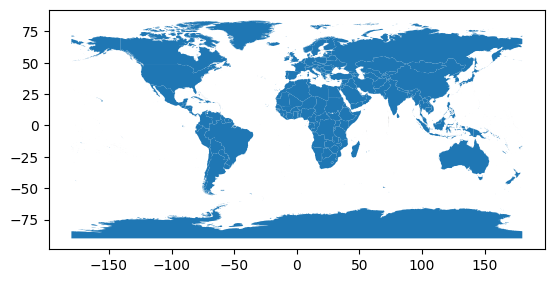

In [103]:
## Corta puntos dento de los polígonos de los paises
COUNTRIES_FP = build_path([COUNTRIES_PATH, "ne_10m_admin_0_countries_ind.geojson"])
countries = gpd.read_file(COUNTRIES_FP)
countries.plot()

<Axes: >

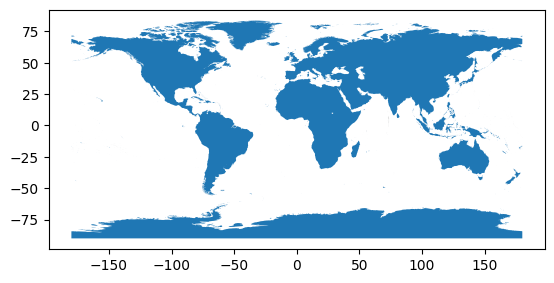

In [104]:
### Creamos un solo polígono del mundo
countries["agrega"] = "mundo"
mundo = countries.dissolve(by='agrega')
mundo.plot()

In [105]:
## Nos quedamos con los puntos dentro del polígono de mundo
gdf_pa_viento = gdf_pa_viento[[mundo.contains(i)["mundo"] for i in gdf_pa_viento.geometry ]]
gdf_pa_solar = gdf_pa_solar[[mundo.contains(i)["mundo"] for i in gdf_pa_solar.geometry ]]

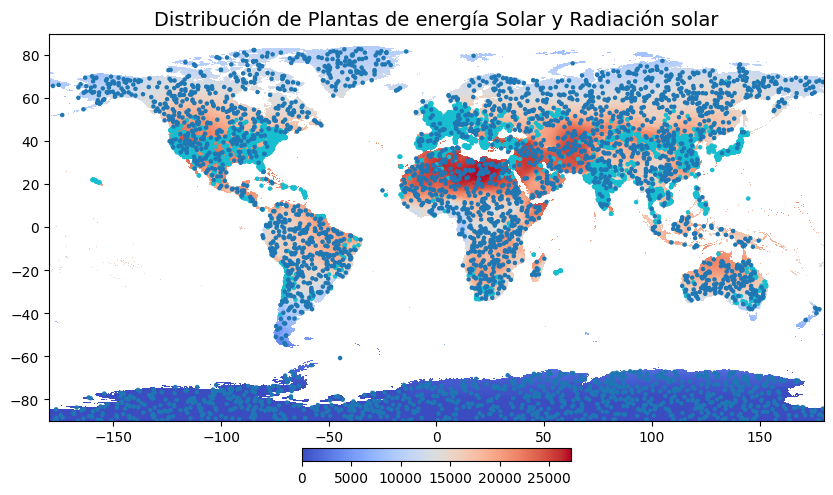

In [106]:
### Visualizamos Presencias y Pseudo-Ausencias
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)

cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.025,
    'pad': 0.05,
    'extend':'neither'
}

raster.plot.imshow(
    ax=ax, add_labels=False,
    cmap='coolwarm', cbar_kwargs=cbar_kwargs)
gdf_pa_solar.plot(column='presencia', categorical=True, ax=ax, markersize=5)
ax.set_xlim([raster.x.min(), raster.x.max()])
ax.set_ylim([raster.y.min(), raster.y.max()])
ax.set_title(f'Distribución de Plantas de energía {energia} y Radiación solar', fontsize = 14)
ax.set_aspect('equal')

plt.show()

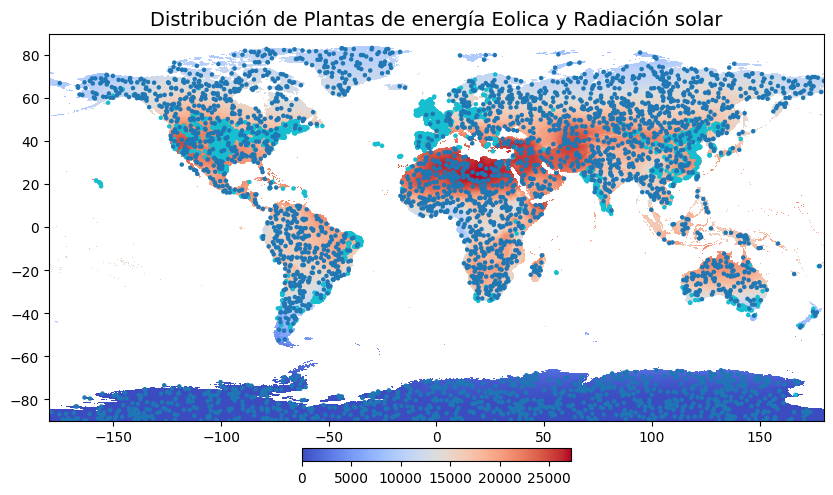

In [107]:
### Visualizamos Presencias y Pseudo-Ausencias
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)

cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.025,
    'pad': 0.05,
    'extend':'neither'
}

raster.plot.imshow(
    ax=ax, add_labels=False,
    cmap='coolwarm', cbar_kwargs=cbar_kwargs)
gdf_pa_viento.plot(column='presencia', categorical=True, ax=ax, markersize=5)
ax.set_xlim([raster.x.min(), raster.x.max()])
ax.set_ylim([raster.y.min(), raster.y.max()])
ax.set_title('Distribución de Plantas de energía Eolica y Radiación solar', fontsize = 14)
ax.set_aspect('equal')

plt.show()

## Regresión Logística para estimar la probabilidad de presencia de una planta de poder dado el paisaje

## Python module for geospatial prediction using scikit-learn and rasterio

In [115]:
from pyimpute import load_training_vector, load_targets, impute, evaluate_clf
from sklearn.ensemble import RandomForestClassifier

# Guardamos nuestros data frames como geojson para que sean procesados 
DATA_MODEL_PATH = build_path([DATA_PATH, "pyimpute_data"])
DATA_VIENTO_PA = build_path([DATA_MODEL_PATH, "pa_viento_to_model.geojson"])
DATA_SOLAR_PA = build_path([DATA_MODEL_PATH, "pa_solar_to_model.geojson"])

# Guardamos los dataframes como geojson
gdf_pa_viento.to_file(DATA_VIENTO_PA, driver="GeoJSON")
gdf_pa_solar.to_file(DATA_SOLAR_PA, driver="GeoJSON")


In [117]:

# Load some training data

explanatory_rasters = [
            build_path([BIOCLIM_PATH, "wc2.1_10m_bio_1.tif"]), # Annual Mean Temperature
            build_path([BIOCLIM_PATH, "wc2.1_10m_bio_3.tif"]), # Isothermality (BIO2/BIO7) (×100)
            build_path([BIOCLIM_PATH, "wc2.1_10m_bio_4.tif"]), # Max Temperature of Warmest Month
            build_path([BIOCLIM_PATH, "wc2.1_10m_bio_5.tif"]), # Min Temperature of Coldest Month
            build_path([BIOCLIM_PATH, "wc2.1_10m_bio_12.tif"]), # Annual Precipitation
            build_path([SRAD_CLIM_PATH, "wc2.1_10m_srad_08.tif"]), # Solar radiation
            build_path([WIND_CLIM_PATH, "wc2.1_10m_wind_08.tif"]) # Wind
]

## Train a scikit-learn classifier
train_xs, train_y = load_training_vector(DATA_SOLAR_PA,
                                         explanatory_rasters,
                                         response_field="presencia")

In [118]:
# Train a scikit-learn classifier
clf = RandomForestClassifier(n_estimators=10, n_jobs=1)
clf.fit(train_xs, train_y)

RandomForestClassifier(n_estimators=10, n_jobs=1)

In [119]:
## Evalute the classifier using several validation metrics, manually inspecting the output
evaluate_clf(clf, train_xs, train_y)

Accuracy Score: 0.931648

Classification report
              precision    recall  f1-score   support

           0       0.90      0.83      0.87      1898
           1       0.94      0.97      0.95      5300

    accuracy                           0.93      7198
   macro avg       0.92      0.90      0.91      7198
weighted avg       0.93      0.93      0.93      7198


Confussion matrix
[[1577  321]
 [ 171 5129]]

Feature importances
                   0: 33.9

                   1: 16.0

                   2: 10.0

                   3: 13.8

                   4: 8.1

                   5: 11.7

                   6: 6.6



## Construyamos el mapa de probabilidades para cada una de las regiones de estudio

Casos de estudio:
*  **Guachochi, Chihuahua (energía solar)**. Guacochi es un municipio en Chihuahua
con una población de 50,180 habitantes con comunidades predominantemente indı́genas.
Este municipio tiene un alto potencial para generación fotovoltaica, de manera que existen
proyectos de energı́a solar con celdas solares a nivel comunitario.
* **Etchojoa, Sonora (energía solar)**. Etchojoa es un municipio en Sonora con una
población de 61,309 habitantes que cuenta con una gran población indı́gena. Este municipio
tiene un alto potencial para generación fotovoltaica; aunque no hay mucha información
pública al respecto, se sabe que el municipio tiene acuerdos con la empresa de generación
eléctrica Sonora80M para producir energı́a solar.
* **La Trinitaria, Chiapas (energía eólica)**. La Trinitaria es un municipio en Chiapas
con una población de 141,027 habitantes y una población mayoritariamente indı́gena. El
municipio tiene un alto potencial para generación eólica y se encuentra en el inventario
nacional de energı́as renovables del paı́s.


In [146]:
## Cargamos geojson de los estados de caso de estudio
CHIAPAS_GJ_FP = build_path([CHIAPAS_PATH, "chiapas_municipios.geojson"])
SONORA_GJ_FP = build_path([SONORA_PATH, "sonora_municipios.geojson"])
CHIHUAHUA_GJ_FP = build_path([CHIHUAHUA_PATH, "chihuahua_municipios.geojson"])

gdf_chiapas = gpd.read_file(CHIAPAS_GJ_FP)
gdf_chihuahua = gpd.read_file(CHIHUAHUA_GJ_FP)
gdf_sonora = gpd.read_file(SONORA_GJ_FP)

<Axes: >

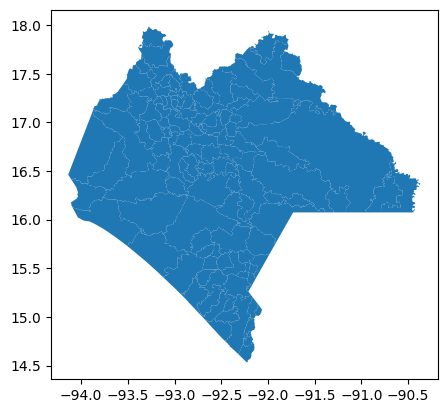

In [149]:
## Graficamos Al estado de Chiapas
gdf_chiapas.plot()

<Axes: >

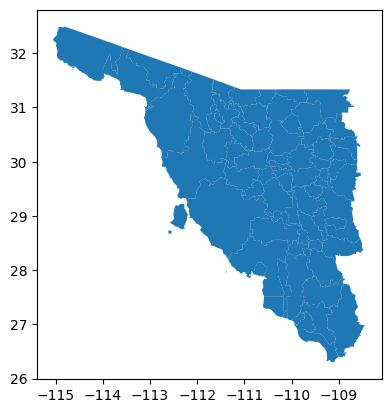

In [150]:
## Graficamos al Estado de Sonora
gdf_sonora.plot()

<Axes: >

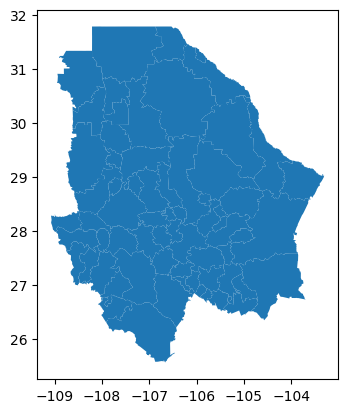

In [151]:
## Graficamos al Estado de Chihuahua
gdf_chihuahua.plot()

### Nos quedamos con los municipios de los casos de estudio

In [157]:
guachochi = gdf_chihuahua.query("CVEGEO=='08027'")
etchojoa = gdf_sonora.query("CVEGEO=='26026'")
trinitaria = gdf_chiapas.query("CVEGEO=='07099'")

<Axes: >

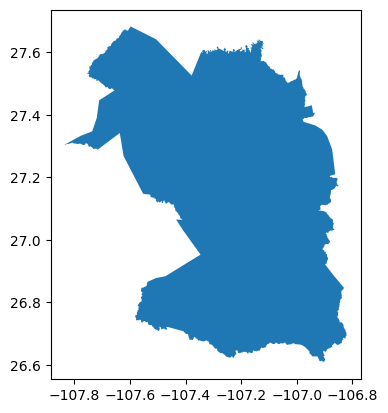

In [159]:
guachochi.plot()

<Axes: >

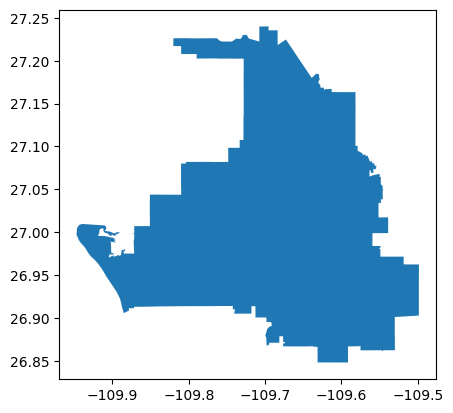

In [280]:
etchojoa.plot()

In [306]:
## Creamos polígonos con los límites del municipio
from shapely.geometry import Point, Polygon, LineString

def crea_poligono(xmin, ymin, xmax, ymax):
    return Polygon([
        (xmax+0.1, ymin-0.1),
        (xmax+0.1, ymax+0.1),
        (xmin-0.1, ymax+0.1),
        (xmin-0.1, ymin-0.1),
    ])

limites_trinitaria = crea_poligono(*trinitaria.total_bounds)
limites_guachochi = crea_poligono(*guachochi.total_bounds)
limites_etchojoa = crea_poligono(*etchojoa.total_bounds)

In [307]:
limites_etchojoa.bounds

(-110.047036990824,
 26.748009596341607,
 -109.39853265320485,
 27.339935503880916)

In [308]:
etchojoa.total_bounds

array([-109.94703699,   26.8480096 , -109.49853265,   27.2399355 ])

In [309]:
## Guardamos los límites de los municipios

TRINITARIA_BOX_FP = build_path([CHIAPAS_PATH, "trinitaria_box.geojson"])
ETCHOJOA_BOX_FP = build_path([SONORA_PATH, "etchojoa_box.geojson"])
GUACHOCHI_BOX_FP = build_path([CHIHUAHUA_PATH, "guachochi_box.geojson"])

df_limites_trinitaria = gpd.GeoDataFrame({'municipio' : ["La Trinitaria"],  'geometry': [limites_trinitaria]},crs="EPSG:4326")
df_limites_etchojoa = gpd.GeoDataFrame({'municipio' : ["Etchojoa"],  'geometry': [limites_etchojoa]},crs="EPSG:4326")
df_limites_guachochi = gpd.GeoDataFrame({'municipio' : ["Guachochi"],  'geometry': [limites_guachochi]},crs="EPSG:4326")

df_limites_trinitaria.to_file(TRINITARIA_BOX_FP, driver="GeoJSON")
df_limites_etchojoa.to_file(ETCHOJOA_BOX_FP, driver="GeoJSON")
df_limites_guachochi.to_file(GUACHOCHI_BOX_FP, driver="GeoJSON")

## Masking a raster using a shapefile

In [310]:
edos_explanatory_rasters = {"chiapas" : [],
                            "sonora" : [],
                            "chihuahua" : []}

def crop_rasters(shape_box, estado):
    with fiona.open(shape_box, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

        for raster_data in explanatory_rasters:
            with rasterio.open(raster_data) as src:
                    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
                    out_meta = src.meta
                    out_meta.update({"driver": "GTiff",
                                 "height": out_image.shape[1],
                                 "width": out_image.shape[2],
                                 "transform": out_transform})

                    CROP_RASTER_FP = build_path([CASOS_ESTUDIO_PATH, estado, "rasters", raster_data.replace(".tif", "_crop.tif").split("/")[-1]])
                    with rasterio.open(CROP_RASTER_FP, "w", **out_meta) as dest:
                        dest.write(out_image)

                    edos_explanatory_rasters[estado].append(CROP_RASTER_FP)

boxes = [TRINITARIA_BOX_FP, ETCHOJOA_BOX_FP, GUACHOCHI_BOX_FP]
estados = ["chiapas", "sonora", "chihuahua"]

for box,estado in zip(boxes, estados):
    crop_rasters(box, estado)

In [315]:
# Load target raster data
target_xs, raster_info = load_targets(edos_explanatory_rasters["sonora"])
impute(target_xs, clf, raster_info, outdir='/home/milo/Documents/egtp/clases/2025/ccm/ltp/analisis_decisiones_bajo_incertidumbre/data/reto/casos_estudio/sonora/outputs',
        linechunk=400, class_prob=True, certainty=True)


In [316]:
### Carga raster
raster = rxr.open_rasterio("/home/milo/Documents/egtp/clases/2025/ccm/ltp/analisis_decisiones_bajo_incertidumbre/data/reto/casos_estudio/sonora/outputs/probability_1.tif", mask_and_scale=True)

### Selecciona datos en banda 1
raster =  raster.sel(band=1)

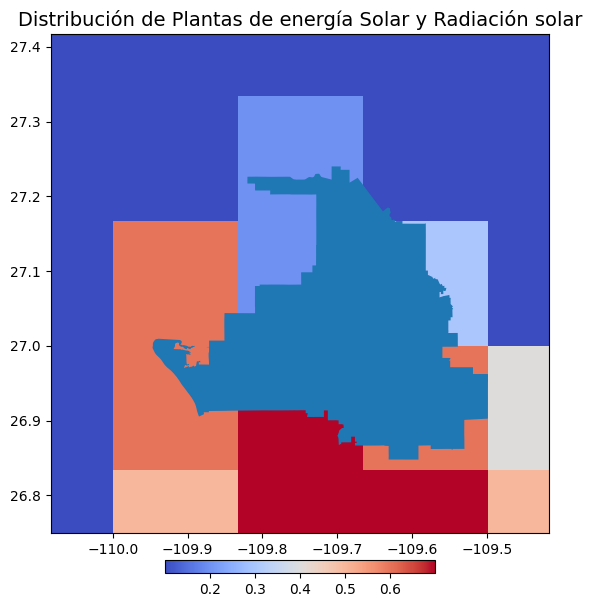

In [317]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)

cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.025,
    'pad': 0.05,
    'extend':'neither'
}

raster.plot.imshow(
    ax=ax, add_labels=False,
    cmap='coolwarm', cbar_kwargs=cbar_kwargs)
etchojoa.plot(ax=ax, markersize=5)
ax.set_xlim([raster.x.min(), raster.x.max()])
ax.set_ylim([raster.y.min(), raster.y.max()])
ax.set_title(f'Distribución de Plantas de energía {energia} y Radiación solar', fontsize = 14)
ax.set_aspect('equal')

plt.show()